<a href="https://colab.research.google.com/github/w15d0177/AIFFEL_quest_cr/blob/main/Exploration/Quest03/CLIPSeg_shared_by_Seongjin_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import torch
import requests
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageFilter
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation

### ++ import image

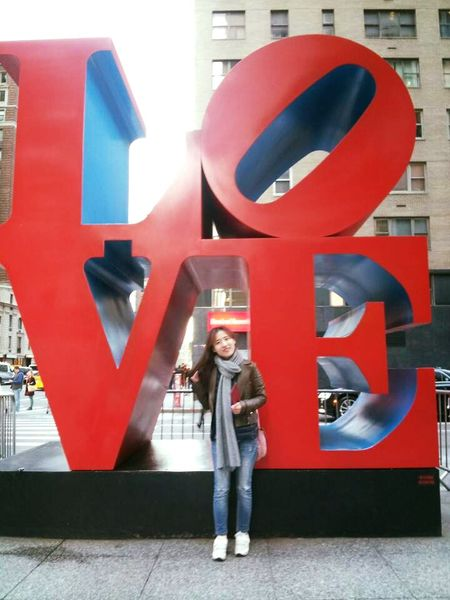

In [87]:
url = "https://scontent-ssn1-1.xx.fbcdn.net/v/t39.30808-6/465164113_9380913741936314_742016361854047708_n.jpg?stp=dst-jpg_s600x600&_nc_cat=104&ccb=1-7&_nc_sid=833d8c&_nc_ohc=SHB1Vy71YIMQ7kNvgEMkZYf&_nc_zt=23&_nc_ht=scontent-ssn1-1.xx&_nc_gid=A2_Amot4yRpWyfuNSynNpG5&oh=00_AYB4KqeUxg2EiLu46SdqMiPclKBDB8lvAU9JhzbKbz-Viw&oe=674DA4C6"
image = Image.open(requests.get(url, stream=True).raw)
image

In [88]:
image.size

(450, 600)

### ++ segmentation

In [89]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [90]:
prompts = ["building", "structure", "person"]

In [91]:
inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")

# predict
with torch.no_grad():
  outputs = model(**inputs, interpolate_pos_encoding=True)

preds = outputs.logits.unsqueeze(1)


/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


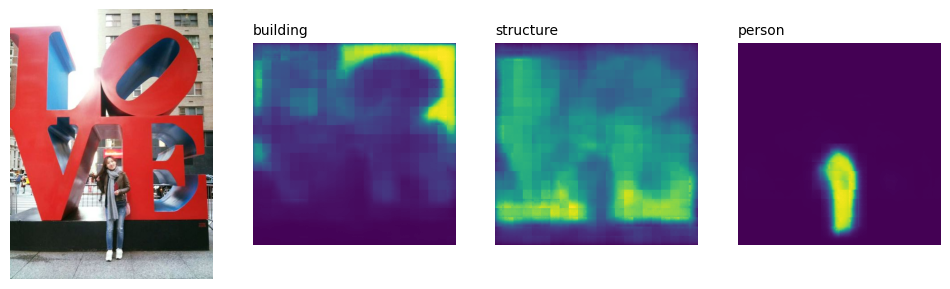

In [92]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(image)
[ax[i+1].imshow(torch.sigmoid(preds[i][0])) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

### ++ shallow focus effect

In [93]:
def make_shallow_focus(segmentation_image, original_image):
    segmentation_map = segmentation_image.cpu().numpy()

    # Normalize segmentation map to range 0-1
    segmentation_map = (segmentation_map - segmentation_map.min()) / (segmentation_map.max() - segmentation_map.min())

    # Convert the segmentation map to uint8 for processing
    segmentation_map = (segmentation_map * 255).astype(np.uint8)

    # Create a PIL image from the segmentation map
    segmentation_image = Image.fromarray(segmentation_map)

    # Resize the segmentation image to match the original image
    segmentation_image = segmentation_image.resize(original_image.size) # Resize segmentation map

    # Image to numpy array
    img_array = np.array(original_image)
    img_uint8 = (img_array).astype(np.uint8)

    # Create a blurred version of the original image
    blurred_image = Image.fromarray(img_uint8).filter(ImageFilter.GaussianBlur(radius=20))

    # Create a shallow-focused image using the segmentation map
    shallow_focus = Image.composite(Image.fromarray(img_uint8), blurred_image, segmentation_image)

    return shallow_focus

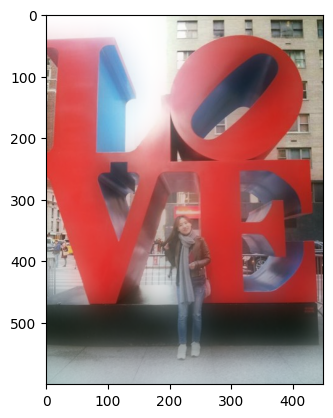

In [94]:
shallow_focus = make_shallow_focus(preds[0][0], image)
plt.imshow(shallow_focus)

In [95]:
# save the final shallow-focused image
shallow_focus.save("shallow_focused_image_robot.jpg")  # Save the image

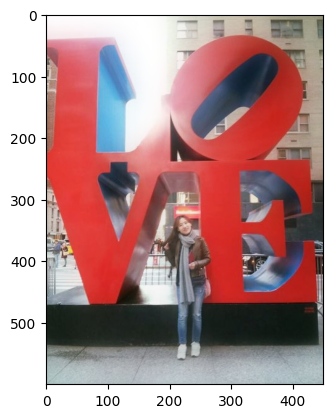

In [96]:
shallow_focus = make_shallow_focus(preds[1][0], image)
plt.imshow(shallow_focus)

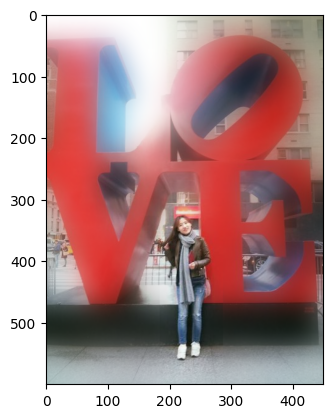

In [97]:
shallow_focus = make_shallow_focus(preds[2][0], image)
plt.imshow(shallow_focus)